# Detecting temperature targets
##### authors: Elizabeth A. Barnes and Noah Diffenbaugh
##### date: March 20, 2022

README:
This is the main training script for all TF models. Here are some tips for using this new re-factored code.

* ```experiment_settings.py``` is now your go-to place. It is something like a research log. You want to continue to copy and paste new experimental designs (with unique names e.g. ```exp23```) and this way you can always refer back to an experiment you ran before without having to change a bunch of parameters again. 

* If all goes well and we don't need more data, you should only be modifying the file called ```experiment_settings.py``` and this notebook (although plots.py might be changed too). 

* To train a set of moodels, you go into ```experiment_settings.py``` and make a new experiment (with a new name, e.g. ```exp1``` and then you specify that same name here in Cell 3 for ```EXP_NAME```.

* The parameter in settings called ```n_models```, will be more useful now. If you set this to a larger number, e.g. 20, it will train 20 models with the same experimental design but with different random training/validation/testing sets etc. You will then be able to analyze these models in another notebook.

* Other choices you have here (outside of the usual experiment settings) is whether to overwrite existing models with the name experiment name. Typically, you want ```OVERWRITE_MODEL = False``` so that the code will continue training new random seeds where you left off (rather than starting over again).

* Plots for model diagnostics are saved in the ```model_diagnostics``` directory. 

* Predictions for observations are saved in the ```saved_predictions``` directory, although you can always re-load the TF model and re-make the predictions in another notebook. But I thought this might be faster/easier.

* TF models and their meta data are saved in the ```saved_models``` directory.

* Once training is done, you can run the following to perform analysis and make/save plots for the paper. 
** ```compare_random_seeds.ipynb```
** ```_analyze_models_vX.X.ipynb```
** ```_visualize_xai_vX.X.ipynb```

## Python stuff

In [1]:
import sys, imp, os

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
import tensorflow_probability as tfp

import experiment_settings
import file_methods, plots, custom_metrics, network, data_processing

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

/var/folders/sw/7glfsp2j5w3cw43s572xlj9r0000gn/T/ipykernel_52172/1615758800.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import sys, imp, os


In [2]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")  
print(f"tensorflow version = {tf.__version__}")  
print(f"tensorflow-probability version = {tfp.__version__}")  

python version = 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) 
[Clang 13.0.1 ]
numpy version = 1.19.5
xarray version = 2022.6.0
tensorflow version = 2.7.0
tensorflow-probability version = 0.15.0


## User Choices

In [3]:
# EXP_NAME_LIST = ('exp15C_126_nohigh10','exp15C_126_nohigh7','exp15C_126_nohigh5','exp15C_126_smooth_nohigh10','exp15C_126_smooth_nohigh7','exp15C_126_smooth_nohigh5')
EXP_NAME_LIST = ('exp15C_126_nohigh7',)
OVERWRITE_MODEL = True

MODEL_DIRECTORY = 'saved_models/'        
PREDICTIONS_DIRECTORY = 'saved_predictions/'
DATA_DIRECTORY = 'data/'
DIAGNOSTICS_DIRECTORY = 'model_diagnostics/'
FIGURE_DIRECTORY = 'figures/'

## Plotting functions

In [4]:
def plot_one_to_one_diagnostic():
    if settings['network_type'] == "shash2":
        top_pred_idx = 0
    else:
        top_pred_idx = None

    YEARS_UNIQUE = np.unique(y_yrs_train)
    predict_train = model.predict(x_train)[:,top_pred_idx].flatten()
    predict_val = model.predict(x_val)[:,top_pred_idx].flatten()
    predict_test = model.predict(x_test)[:,top_pred_idx].flatten()
    mae = np.mean(np.abs(predict_test-y_test[:]))
    
    #--------------------------------
    clr = ('tab:purple','tab:orange', 'tab:blue', 'tab:green', 'gold', 'brown','black','darkorange','fuchsia','cornflowerblue','lime')
    plt.subplots(1,2,figsize=(15,6))

    plt.subplot(1,2,1)
    plt.plot(y_train, predict_train,'.',color='gray',alpha=.25, label='training')
    plt.plot(y_val, predict_val,'.', label='validation',color='gray',alpha=.75,)
    plt.plot(y_test, predict_test,'.', label='testing')    
    plt.plot(y_train,y_train,'--',color='fuchsia')
    plt.axvline(x=0,color='gray',linewidth=1)
    plt.axhline(y=0,color='gray',linewidth=1)
    plt.title('Testing MAE = ' + str(mae.round(2)) + ' years')
    plt.xlabel('true number of years until target is reached')
    plt.ylabel('predicted number of years until target is reached')
    plt.legend()


    plt.subplot(1,2,2)
    plt.plot(y_yrs_train, predict_train,'.',color='gray',alpha=.5, label='training')
    plt.title('Time to Target Year for ' + str(settings['target_temp']) + 'C using ssp' + str(settings['ssp']))
    plt.xlabel('year of map')
    plt.ylabel('predicted number of years until target is reached')
    plt.axhline(y=0, color='gray', linewidth=1)

    predict_val_mat = predict_val.reshape(N_GCMS,N_VAL,len(YEARS_UNIQUE))
    for i in np.arange(0,predict_val_mat.shape[0]):
        plt.plot(YEARS_UNIQUE, predict_val_mat[i,:,:].swapaxes(1,0),'.', label='validation', color=clr[i])
        plt.axvline(x=target_years[i],linestyle='--',color=clr[i])

## Train the network

{'save_model': True,
 'n_models': 4,
 'ssp': '126',
 'gcmsub': 'noHIGH7',
 'obsdata': 'BEST',
 'smooth': False,
 'target_temp': 1.5,
 'n_train_val_test': (3, 1, 1),
 'baseline_yr_bounds': (1850, 1899),
 'training_yr_bounds': (1970, 2100),
 'anomaly_yr_bounds': (1951, 1980),
 'remove_sh': False,
 'anomalies': True,
 'remove_map_mean': False,
 'network_type': 'shash2',
 'hiddens': [25, 25],
 'dropout_rate': 0.0,
 'ridge_param': [10.0, 0.0],
 'learning_rate': 1e-05,
 'batch_size': 64,
 'rng_seed': 8889,
 'seed': None,
 'act_fun': ['relu', 'relu'],
 'n_epochs': 25000,
 'patience': 50,
 'exp_name': 'exp15C_126_nohigh7'}

observations: filling NaNs with zeros
np.shape(x_obs) = (172, 10368)
[2 3 0] [1] [4]
tas_Amon_historical_ssp126_MIROC6_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2060, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_MIROC-ES2L_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2034, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_MRI-ESM2-0_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2031, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_ACCESS-ESM1-5_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2032, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_CNRM-CM6-1_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2027, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_CNRM-ESM2-1_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2035, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_GISS-E2-1-G_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2030, TARGET_TEMP = 1.5
---------------------------
data_train.shape = (21, 131, 72, 144)
data_val.shape = (7, 131, 72, 144)
data_test.shape = (7, 131, 72, 14

2022-11-02 05:57:13.130515: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10368)]      0           []                               
                                                                                                  
 normalization (Normalization)  (None, 10368)        20737       ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 10368)        0           ['normalization[0][0]']          
                                                                                                  
 dense (Dense)                  (None, 25)           259225      ['dropout[0][0]']                
                                                                                              

2022-11-02 05:58:41.009525: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_models/exp15C_126_nohigh7_seed1257_model/assets


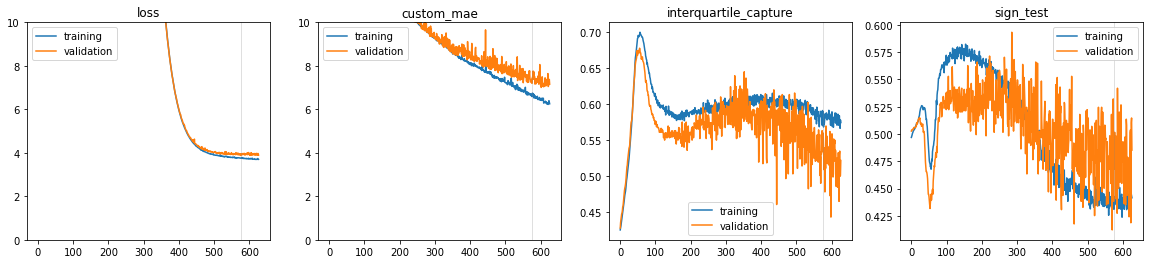

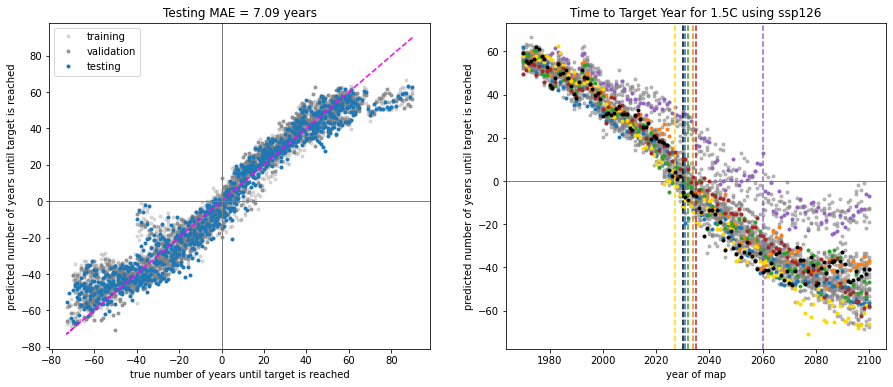

observations: filling NaNs with zeros
np.shape(x_obs) = (172, 10368)
[4 3 0] [2] [1]
tas_Amon_historical_ssp126_MIROC6_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2060, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_MIROC-ES2L_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2034, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_MRI-ESM2-0_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2031, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_ACCESS-ESM1-5_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2032, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_CNRM-CM6-1_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2027, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_CNRM-ESM2-1_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2035, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_GISS-E2-1-G_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2030, TARGET_TEMP = 1.5
---------------------------
data_train.shape = (21, 131, 72, 144)
data_val.shape = (7, 131, 72, 144)
data_test.shape = (7, 131, 72, 14

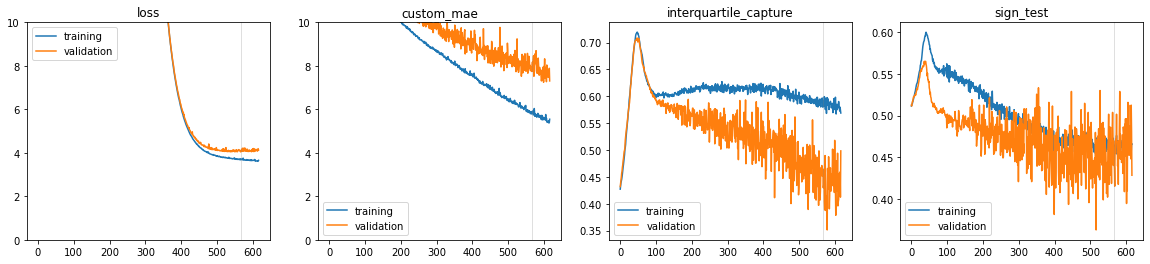

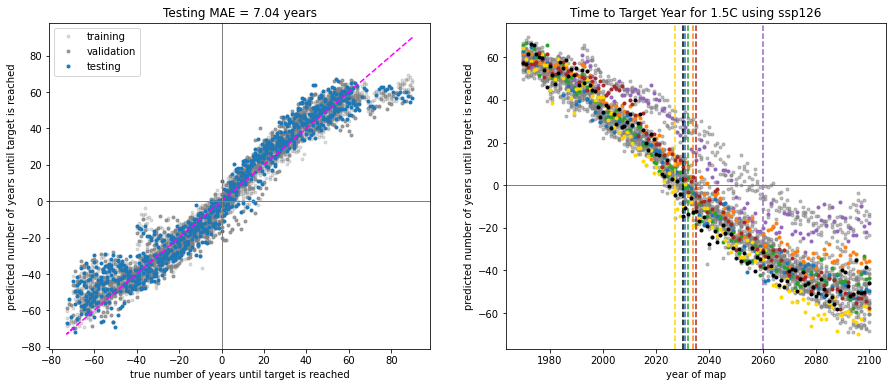

observations: filling NaNs with zeros
np.shape(x_obs) = (172, 10368)
[4 0 2] [1] [3]
tas_Amon_historical_ssp126_MIROC6_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2060, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_MIROC-ES2L_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2034, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_MRI-ESM2-0_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2031, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_ACCESS-ESM1-5_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2032, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_CNRM-CM6-1_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2027, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_CNRM-ESM2-1_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2035, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_GISS-E2-1-G_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2030, TARGET_TEMP = 1.5
---------------------------
data_train.shape = (21, 131, 72, 144)
data_val.shape = (7, 131, 72, 144)
data_test.shape = (7, 131, 72, 14

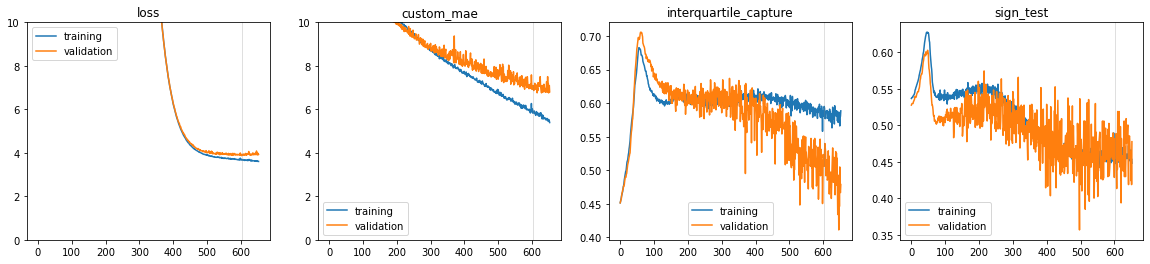

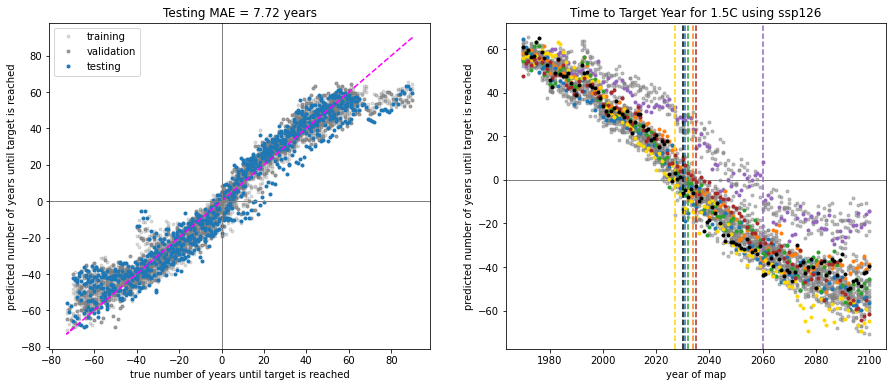

observations: filling NaNs with zeros
np.shape(x_obs) = (172, 10368)
[4 3 1] [0] [2]
tas_Amon_historical_ssp126_MIROC6_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2060, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_MIROC-ES2L_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2034, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_MRI-ESM2-0_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2031, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_ACCESS-ESM1-5_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2032, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_CNRM-CM6-1_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2027, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_CNRM-ESM2-1_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2035, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_GISS-E2-1-G_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2030, TARGET_TEMP = 1.5
---------------------------
data_train.shape = (21, 131, 72, 144)
data_val.shape = (7, 131, 72, 144)
data_test.shape = (7, 131, 72, 14

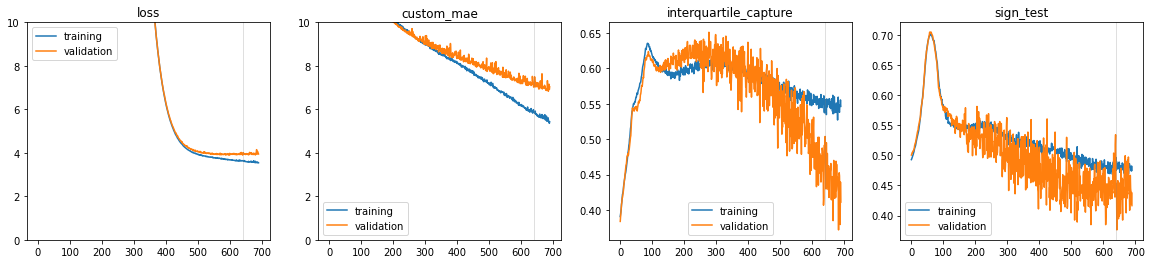

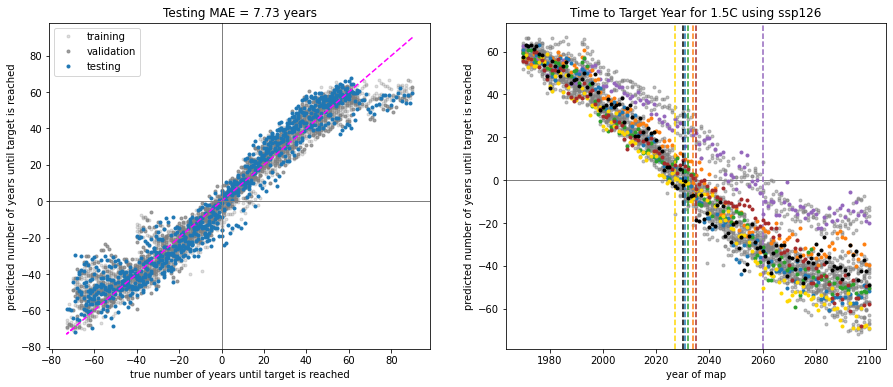

In [5]:
imp.reload(data_processing)
for EXP_NAME in EXP_NAME_LIST:

    settings = experiment_settings.get_settings(EXP_NAME)
    display(settings)

    # define random number generator
    rng = np.random.default_rng(settings["rng_seed"])
    
    # define early stopping callback (cannot be done elsewhere)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       patience=settings['patience'],
                                                       verbose=1,
                                                       mode='auto',
                                                       restore_best_weights=True)    

    for iloop in np.arange(settings['n_models']):
        seed = rng.integers(low=1_000,high=10_000,size=1)[0]
        settings["seed"] = int(seed)
        tf.random.set_seed(settings["seed"])
        np.random.seed(settings["seed"])

        # get model name
        model_name = file_methods.get_model_name(settings)
        if os.path.exists(MODEL_DIRECTORY + model_name + "_model") and OVERWRITE_MODEL==False:
            print(model_name + 'exists. Skipping...')
            print("================================\n")
            continue   
            
        # load observations for diagnostics plotting and saving predictions
        da_obs, x_obs, global_mean_obs = data_processing.get_observations(DATA_DIRECTORY, settings)
        N_TRAIN, N_VAL, N_TEST, ALL_MEMBERS = data_processing.get_members(settings)            

        # get the data
        (x_train, 
         x_val, 
         x_test, 
         y_train, 
         y_val, 
         y_test, 
         onehot_train, 
         onehot_val, 
         onehot_test, 
         y_yrs_train, 
         y_yrs_val, 
         y_yrs_test, 
         target_years, 
         map_shape,
         settings) = data_processing.get_cmip_data(DATA_DIRECTORY, settings)

        ## determine how many GCMs are being used for later re-shaping
        N_GCMS = len(file_methods.get_cmip_filenames(settings, verbose=0))

        #----------------------------------------        
        tf.keras.backend.clear_session()                
        model = network.compile_model(x_train, y_train, settings)
        history = model.fit(x_train, onehot_train, 
                            epochs=settings['n_epochs'], 
                            batch_size = settings['batch_size'], 
                            shuffle=True,
                            validation_data=[x_val, onehot_val],
                            callbacks=[early_stopping,],
                            verbose=0,                        
                           )
        #----------------------------------------
        # create predictions for observations with this model
        pred_obs = model.predict(x_obs)

        #----------------------------------------
        # save the tensorflow model and obs predictions
        if settings["save_model"]:
            file_methods.save_tf_model(model, model_name, MODEL_DIRECTORY, settings)
            file_methods.save_pred_obs(pred_obs, 
                                       PREDICTIONS_DIRECTORY+model_name + '_obs_predictions',
                                      )

        #----------------------------------------
        # create and save diagnostics plots
        plots.plot_metrics_panels(history,settings)
        plt.savefig(DIAGNOSTICS_DIRECTORY + model_name + '_metrics_diagnostic' + '.png', dpi=savefig_dpi)
        plt.show()             

        plot_one_to_one_diagnostic()
        plt.savefig(DIAGNOSTICS_DIRECTORY + model_name + '_one_to_one_diagnostic' + '.png', dpi=savefig_dpi)
        plt.show()   


In [6]:
2+2

4